In [2]:
import pandas as pd
import numpy as np

from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc  
from GPyOpt.methods import BayesianOptimization

from sklearn.metrics import mean_squared_error, r2_score

Neural Network Model for Hyper Parameter Tuning

In [3]:
sinx = lambda X, Y: (X * np.sin(X)) + (Y * np.sin(Y))
ackley = lambda X, Y: -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)
beale = lambda X, Y: -((1.5 - X + X * Y)**2 + (2.25 - X + X * Y**2)**2 + (2.625 - X + X * Y**3)**2)
Himmelblau = lambda X, Y: -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)

In [4]:
objectives = {
    "sinx": {
        "func": sinx,
        "bounds": [(-5, 18), (-5, 18)],
        "global_max": [{"X": 14.28, "Y": 14.28, "Z": sinx(14.28, 14.28)}]
    },
    "ackley": {
        "func": ackley,
        "bounds": [(-35, 35), (-35, 35)],
        "global_max": [{"X": 0.0, "Y": 0.0, "Z": ackley(0.0, 0.0)}]
    },
    "beale": {
        "func": beale,
        "bounds": [(-4.5, 4.5), (-4.5, 4.5)],
         "global_max": [{"X": 3, "Y": 0.5, "Z": beale(3.0, 0.5)}]
    },
    "Himmelblau": {
        "func": Himmelblau,
        "bounds": [(-5, 5), (-5, 5)],
        "global_max": [
            {"X": 3, "Y":  2, "Z": Himmelblau(3,  2)},
            {"X": -2.805, "Y":  3.131, "Z": Himmelblau(-2.805, 3.131)},
            {"X": -3.779, "Y":  -3.283, "Z": Himmelblau(-3.779, -3.283)},
            {"X": 3.584, "Y":  -1.848, "Z": Himmelblau(3.584, -1.848)},
        ]
    },
}

In [5]:
# Set Becnhmark Function For Use
selected_obj = objectives["sinx"]

# Unpack function and bounds
benchmark_func = selected_obj["func"]
bounds = selected_obj["bounds"]
global_max_points = selected_obj["global_max"]

# Unpack x and y bounds
x_range, y_range = bounds

# Used for Meshgrid
GRID_RESOLUTION = 100

In [6]:
# Random seed
np.random.seed(1)

# Number of observations to train the Neural Network on before starting the active learning loop
pretrain_n = 10

# Number of simulated observations to train the Neural Network on after performing LHS
train_sim = 100

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [7]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [8]:
# Generate n random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(x_range[0], x_range[1], pretrain_n)
Y = np.random.uniform(y_range[0], y_range[1], pretrain_n)

# Calculate the outputs using a predefined benchmark function
output1 = benchmark_func(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({'x': X, 'y': Y, 'z': output1})

In [9]:
sim_eval = lambda x, y, a, b: benchmark_func(x, y) + sim_err(x, y, a, b)

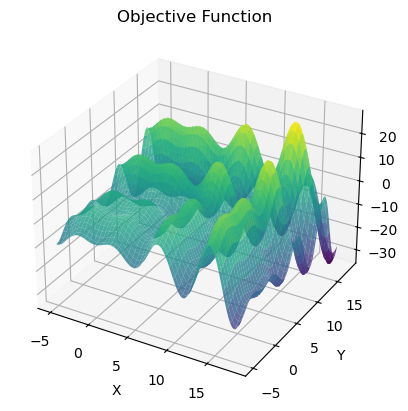

In [10]:
import matplotlib.pyplot as plt

# Create the grid of input values
x1_range = np.linspace(x_range[0], x_range[1], GRID_RESOLUTION)
y1_range = np.linspace(y_range[0], y_range[1], GRID_RESOLUTION)
x_grid, y_grid = np.meshgrid(x1_range, y1_range)

# Evaluate function on grid
z_grid = benchmark_func(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Objective Function')

# Show the plot
plt.show()

In [11]:
# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [12]:
# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_max_points)
global_maxima_df

,X,Y,Z
0,14.28,14.28,28.269165


In [13]:
def perform_iteration(df):

    def sim_all(x):
        df["a"] = x[0,0]
        df["b"] = x[0,1]
        df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
        df["diff"] = df["z"] - df["sim_z"]
        return (df["diff"]**2).sum()

    bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
            {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

    # Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
    bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
    bo.run_optimization(max_iter=max_bo_iter)
    df["a"] = bo.x_opt[0]
    df["b"] = bo.x_opt[1]
    print(bo.x_opt)

    # Create the grid of input values
    sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

    # Create the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors')

    # Show the plot
    plt.show()

    # Generate points using Latin Hypercube Sampling (LHS)
    lhs= qmc.LatinHypercube(d=2, optimization="random-cd")
    lhs_samples = lhs.random(n=train_sim)

    scaled_samples = qmc.scale(lhs_samples, [x_range[0], y_range[0]], [x_range[1], y_range[1]])

    selected_points_df = pd.DataFrame(scaled_samples, columns=['x', 'y'])
    selected_points_df['sim_z'] = sim_eval(selected_points_df['x'], selected_points_df['y'], bo.x_opt[0], bo.x_opt[1])

    sim_df = df[["x", "y", "sim_z"]]
    sim_df = pd.concat([sim_df, selected_points_df], axis=0, ignore_index=True)

    # Train the model with the given hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=6,
        num_units=300,
        learning_rate=0.0007,
        dropout_rate=0.5
    )

    # Standardize the Dataset of Simulation Responses
    scaler= StandardScaler().fit(sim_df[['x', 'y']])
    X_scaled = scaler.transform(sim_df[['x', 'y']])

    # Train the best model on the combined standardized dataset
    best_model.fit(X_scaled, sim_df[['sim_z']], epochs=500, batch_size=128, verbose=1)

    # Create a meshgrid and combine into a single array
    xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    xy_grid_scaled = scaler.transform(xy_grid)
    pred_mean, pred_std = mc_dropout_predictions(best_model, xy_grid_scaled)

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x_grid.shape)

    mean_surface = ax.plot_surface(x_grid, y_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x_grid, y_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x_grid, y_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Customize the plot
    ax.set_title('Neural Network of Simulated Response with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()
    
    x1 = [x_range]
    y1 = [y_range]
    def p_nn(xy):
        xy = np.array(xy).reshape(1, -1)  # Ensure correct shape (1,2)
        xy_scaled = scaler.transform(xy)
        pred_mean, pred_std = mc_dropout_predictions(best_model, xy_scaled)
        # Check if the point is inside the valid domain
        if (x1[0][0] <= xy[0, 0] <= x1[0][1] and 
                y1[0][0] <= xy[0, 1] <= y1[0][1]):
            
            probability = max(pred_mean + 1.96 * pred_std - sim_df["sim_z"].median(), 1e-6)  # Avoid zero
            return probability
        else:
            return 1e-10  # Keep very small but nonzero probability for out-of-bounds case


    def metropolis_step(xy, sig):
        prop_xy = xy + np.random.normal(0, sig, size=xy.shape)  # Generate a candidate

        # Ensure proposed point is inside the valid bounds
        if not (x1[0][0] <= prop_xy[0, 0] <= x1[0][1] and 
                y1[0][0] <= prop_xy[0, 1] <= y1[0][1]):
            return xy  # Reject out-of-bounds proposals

        u = np.random.uniform(0, 1)
        if u < min(1.0, p_nn(prop_xy) / p_nn(xy)):
            return prop_xy  # Accept move
        else:
            return xy  # Stay at current point


    def mh_sampler(sig, sample_size, burn_in, lag):
        # Start at the point with the largest simulated response
        max_idx = np.argmax(sim_df["sim_z"])
        x_init = sim_df["x"].iloc[max_idx]
        y_init = sim_df["y"].iloc[max_idx]
        xy = np.array([[x_init, y_init]])

        # Burn-in phase
        for i in range(burn_in):
            xy = metropolis_step(xy, sig)

        # Sampling phase
        output = xy
        for i in range(sample_size - 1):
            for j in range(lag):
                xy = metropolis_step(xy, sig)
            output = np.vstack((output, xy))  # Stack valid samples

        return output  # Returns an array of shape (sample_size, 2)

    # Find point with highest NN predicted mean response
    flat_pred_mean = pred_mean.flatten()
    max_idx = np.argmax(flat_pred_mean)

    x_max = xy_grid[max_idx, 0]
    y_max = xy_grid[max_idx, 1]
    max_point = np.array([[x_max, y_max]])


    X_mh = mh_sampler(sig=5, sample_size=pretrain_n - 1, burn_in=50, lag=20)

    X_all = np.vstack([max_point, X_mh])

    physical_test_points = pd.DataFrame(X_all, columns=["x", "y"])

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x_grid, y_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Overlay sampled points
    plt.scatter(sim_df['x'], sim_df['y'], color='white', edgecolor='black', label='Simulation Sampled Points')
    plt.scatter(physical_test_points['x'], physical_test_points['y'], color='purple', edgecolor='black', label='Next Physical Test Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    physical_test_points["z"] = benchmark_func(physical_test_points['x'], physical_test_points['y']) + ran_err(pretrain_n, 0.05)
    physical_test_points["a"] = bo.x_opt[0]
    physical_test_points["b"] = bo.x_opt[1]
    physical_test_points["sim_z"] = sim_eval(physical_test_points["x"], physical_test_points["y"], physical_test_points["a"], physical_test_points["b"])
    physical_test_points["diff"] = physical_test_points["z"] - physical_test_points["sim_z"]

    # Heatmap of Simulated Points 
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the heatmap for sim_z_grid
    heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

    # Overlay scatter points for sampling points
    ax.scatter(df["x"], df["y"], color='blue', marker='o', label='Previous Sampled Points')
    ax.scatter(sim_df["x"], sim_df["y"], edgecolor='black', facecolors='none', marker='o', label='Sampled Simulation Points')
    ax.scatter(physical_test_points["x"], physical_test_points["y"], color='purple', marker='o', label='Next Physical Test Points')
    for i, row in physical_test_points.iterrows():
        ax.text(row["x"], row["y"], f"({row['x']:.1f}, {row['y']:.1f})", 
                fontsize=8, ha='center', va='bottom', color='black', 
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.5))
    # Overlay scatter points for global maxima
    ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
    ax.legend()

    # Add a color bar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Function Value (Z)')

    # Show the plot
    plt.show()

    # Add points to original dataframe
    df = pd.concat([df, physical_test_points], axis=0, ignore_index=True)

    return df

[ 2.73047019 -3.09689622]


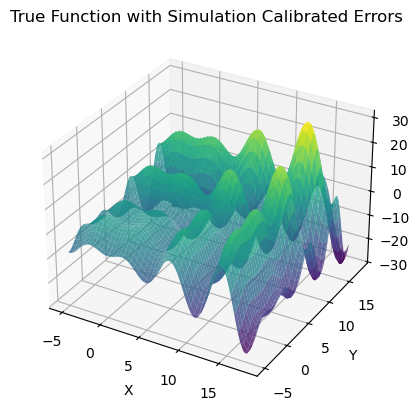

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 109.6492
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 109.5126
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 109.2685
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 108.7131
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 108.3873
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 108.4662
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 107.6346
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 106.8291
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 107.5416
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 106.0865
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 105.8865
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 105.5344
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 106.5871
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 106.5131
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 

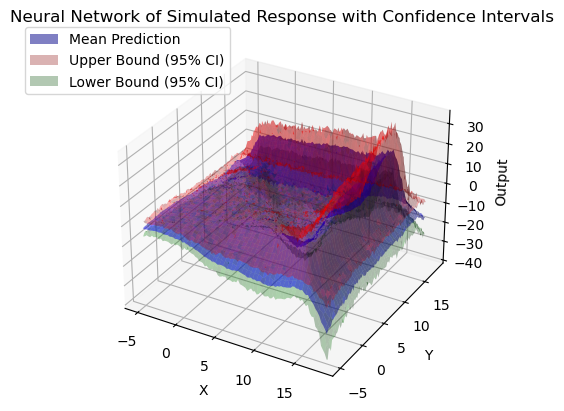

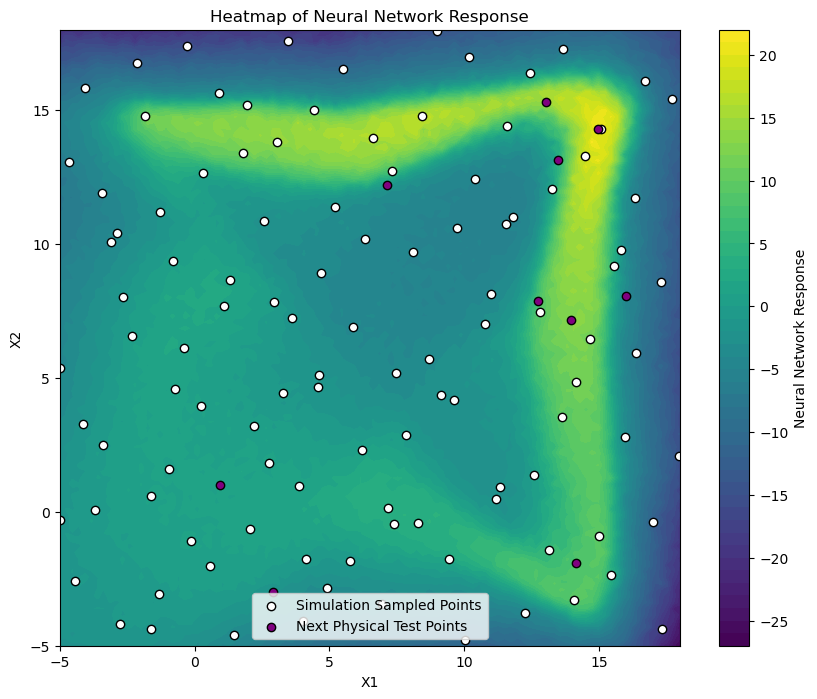

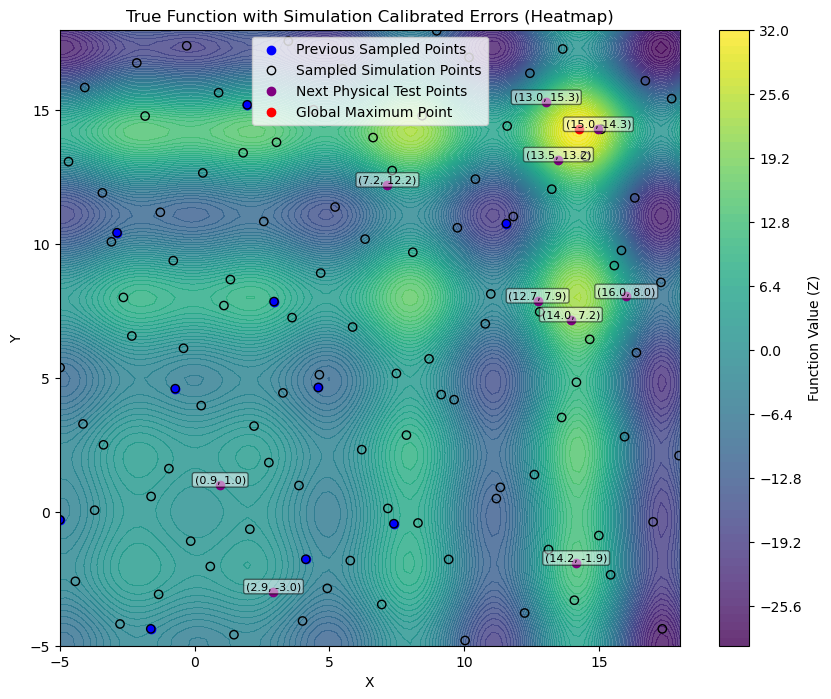

In [14]:
df = perform_iteration(df)